In [1]:
import pandas as pd
from sklearn.metrics.cluster import homogeneity_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import v_measure_score,normalized_mutual_info_score,adjusted_rand_score,silhouette_score
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.metrics import accuracy_score

In [2]:
def highlight_max(s):    
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

In [3]:
def purity_score(y_true, y_pred):
    """Purity score
        Args:
            y_true(np.ndarray): n*1 matrix Ground truth labels
            y_pred(np.ndarray): n*1 matrix Predicted clusters

        Returns:
            float: Purity score
    """
    # matrix which will hold the majority-voted labels
    y_voted_labels = np.zeros(y_true.shape)
    # Ordering labels
    ## Labels might be missing e.g with set like 0,2 where 1 is missing
    ## First find the unique labels, then map the labels to an ordered set
    ## 0,2 should become 0,1
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    # Update unique labels
    labels = np.unique(y_true)
    # We set the number of bins to be n_classes+2 so that 
    # we count the actual occurence of classes between two consecutive bins
    # the bigger being excluded [bin_i, bin_i+1[
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner

    return accuracy_score(y_true, y_voted_labels)

# Import the Data

In [4]:
data = pd.read_csv('cancer.csv')
data.head(2)

,Clump_Thickness,Cell_Size_Uniformity,Cell_Shape_Uniformity,Marginal_Adhesion,Single_Epi_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Bare_Nuclei.1,Class
0,7,4,5,10,2,10.0,3,8,2,malignant
1,5,3,4,1,4,1.0,3,1,1,benign


In [5]:
X, y = data.drop('Class',axis=1) , data['Class']
y_color = y.map({' malignant':'red',' benign':'green'})
y = y.map({' malignant':1,' benign':0})

# Testing the hypothesis that the dataset is divided into two clusters like the number of classes

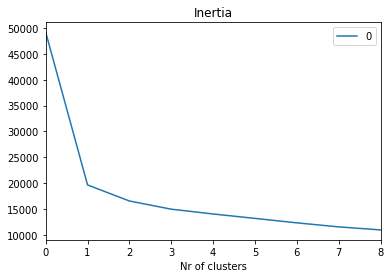

In [6]:
inertia = []
for n in range(1 , 10):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X)
    inertia.append(algorithm.inertia_)
    
ax = pd.DataFrame(inertia).plot(title = "Inertia")
_ = ax.set_xlabel("Nr of clusters")

According to the Kmeans' inertia, 2 clusters seem to be a good hypothesis

# Applying some Dimentionality Reduction for plotting

In [7]:
pca2d = PCA(n_components=2)
pca3d = PCA(n_components=3)

In [8]:
pca_fitted2d = pca2d.fit_transform(X)
pca_fitted3d = pca3d.fit_transform(X)

# Lets 


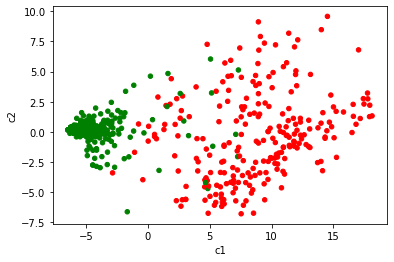

In [9]:
pca_fitted = pd.DataFrame(pca_fitted2d,columns = ['c1','c2']).join(y)
pca_fitted.plot.scatter('c1','c2',c=y_color)

In [10]:
import chart_studio.plotly as py 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
trace = go.Scatter3d(
    x = pca_fitted3d[:,0],
    y = pca_fitted3d[:,1],
    z = pca_fitted3d[:,2],
    mode = 'markers',
    marker=dict(
        color=y_color,
        size=4)
)

data = [trace]

# Plot and embed in ipython notebook!
iplot(data, filename='basic-scatter')

The 3D Plot does not show any evident information about the two clusters, so, the 2 first principal components might be enough to explain the clusters

# Testing hierarquical clusterings



In [11]:
def get_all_metrics(y,y_pred,X):
    return homogeneity_score(y,y_pred),v_measure_score(y,y_pred),purity_score(y,y_pred),normalized_mutual_info_score(y,y_pred),adjusted_rand_score(y,y_pred),silhouette_score(X,y_pred)

def cluster_analysis(X,y,affinity = 'euclidean', linkage='ward',plot=True):
    try:
        model = AgglomerativeClustering(n_clusters=2, affinity=affinity, linkage=linkage)
        model.fit(X)
        labels = model.labels_
    
        results_table.append(get_all_metrics(y,labels,X))
        columns.append(f'{affinity} + {linkage}')

        cmap = {0:'r',1:'g'}
        c =[cmap[l] for l in labels]
        
        if plot == True:
            pca_fitted.plot.scatter('c1','c2',c=c,title = f"{affinity} + {linkage}")
            plt.show()
        return labels
    except:
        pass

## - Testing different linkage:
    Single, complete, average, ward
## - And distance measures:
    euclidean, l1, l2, manhattan, cosine
   (If linkage is "ward", only "euclidean" is accepted.)
## - See if it is the same groups that appear

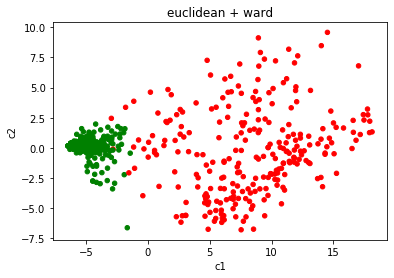

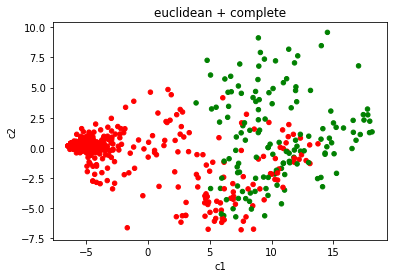

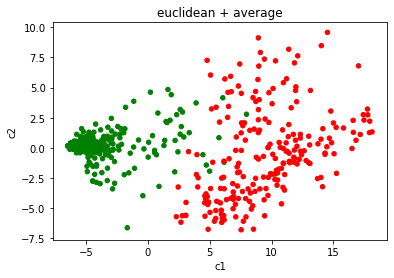

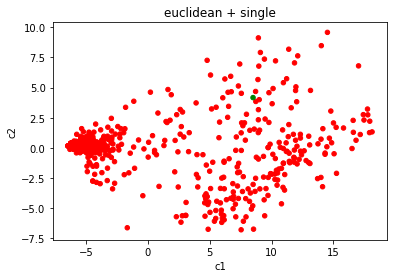

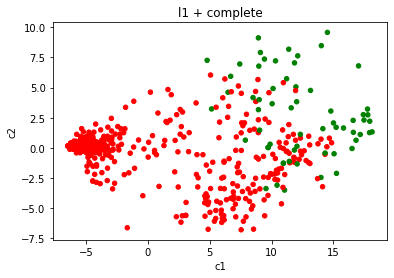

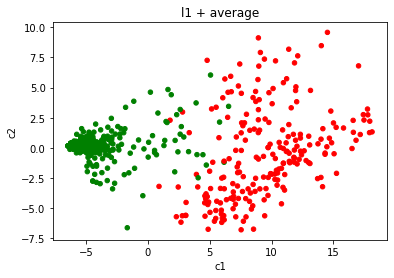

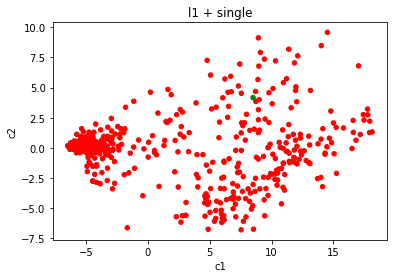

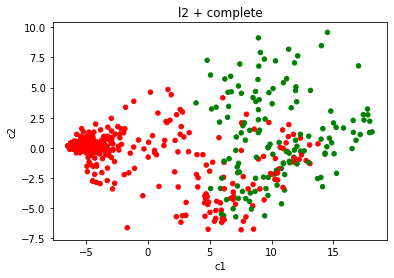

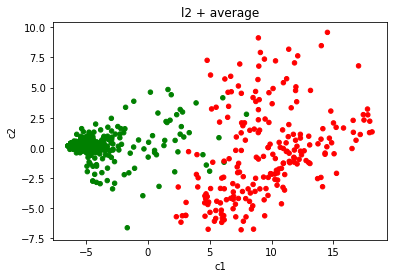

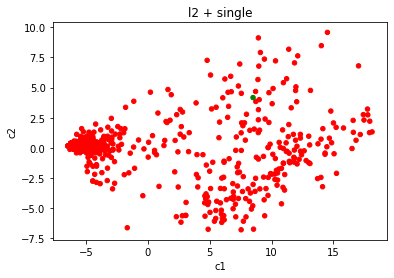

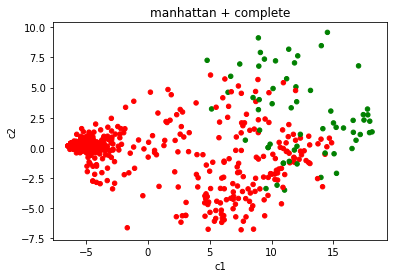

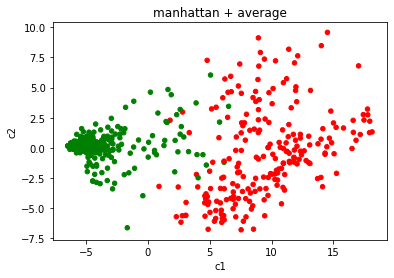

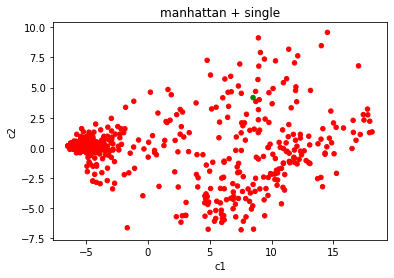

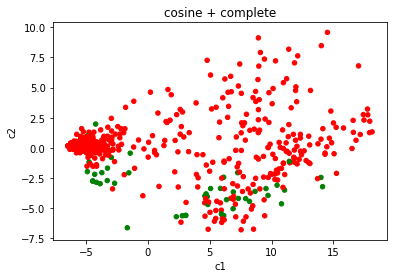

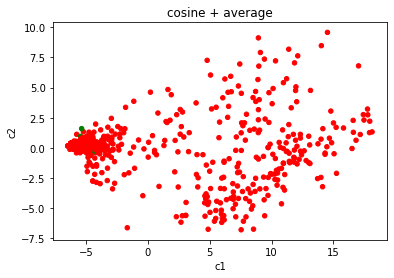

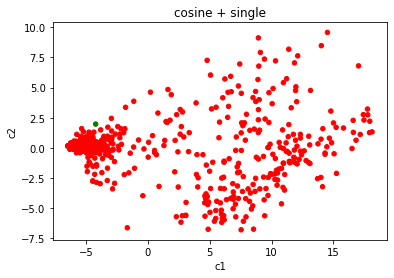

In [12]:
results_table = []
columns = []
for a in ["euclidean", "l1", "l2","manhattan", "cosine"]:
    for l in ["ward", "complete", "average", "single"]:
        cluster_analysis(X,y,a,l)

There are many configurations that seem to resemble the true classes.
## Quantifying the best results

In [13]:
#drawing the results in an html table
results2 = pd.DataFrame(np.transpose(results_table),columns =columns,index=['homogenity','v measure','purity','normalized mutual info','adjusted rand','silhouette'])
#ordering the columns according to the average score of all the scores and getting the best 4 configurations
results2 = results2[results2.apply(np.mean).sort_values(ascending=False).index].iloc[:,:4]

#Plot and ake the maximum element of each column bold 
results2.style.apply(highlight_max,axis=1)


,euclidean + ward,manhattan + average,l1 + average,l2 + average
homogenity,0.811037,0.686819,0.686819,0.661422
v measure,0.799834,0.697764,0.697764,0.673144
purity,0.965665,0.948498,0.948498,0.942775
normalized mutual info,0.799834,0.697764,0.697764,0.673144
adjusted rand,0.866426,0.801797,0.801797,0.781014
silhouette,0.570553,0.589637,0.589637,0.590208


,euclidean + ward,manhattan + average,l1 + average,l2 + average,Kmeans
homogenity,0.811037,0.686819,0.686819,0.661422,0.739452
v measure,0.799834,0.697764,0.697764,0.673144,0.742724
purity,0.965665,0.948498,0.948498,0.942775,0.959943
normalized mutual info,0.799834,0.697764,0.697764,0.673144,0.742724
adjusted rand,0.866426,0.801797,0.801797,0.781014,0.8444
silhouette,0.570553,0.589637,0.589637,0.590208,0.597166


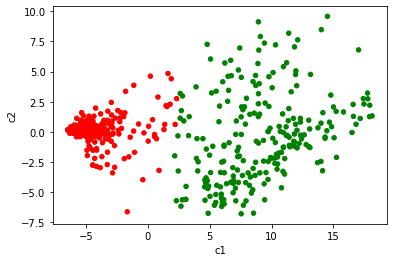

In [14]:
kmeans = KMeans(n_clusters=2,n_init=10).fit(X)
labels_km = kmeans.labels_

results2 = results2.join(pd.Series(get_all_metrics(y,labels_km,X),name = 'Kmeans',index = results2.index))



cmap = {0:'r',1:'g',2:'b',3:'c'}
c_km =[cmap[l] for l in labels_km]
pca_fitted.plot.scatter('c1','c2',c=c_km)

#Plot and ake the maximum element of each column bold 
results2.style.apply(highlight_max,axis=1)

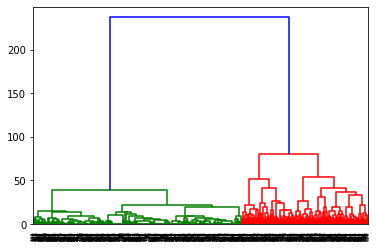

In [15]:
dendrogram = sch.dendrogram(sch.linkage(X, method='ward', metric='euclidean'))


According to the height of the splits in the dendogram of the best configuration of clustering, the hypothesis of 2 clusters that correspond approximatly to the true classes is confirmed

## - TODO MAYEBE? Check stability by adding noise (how much noise until it changes?)
## -TODO MAYBE? Apply the clustering in the PCA

# Intepreting the obtained cluster with a decision tree

In [16]:
cluster_labels = cluster_analysis(X,y,plot=False) #getting the labels of the best configuration
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, cluster_labels)

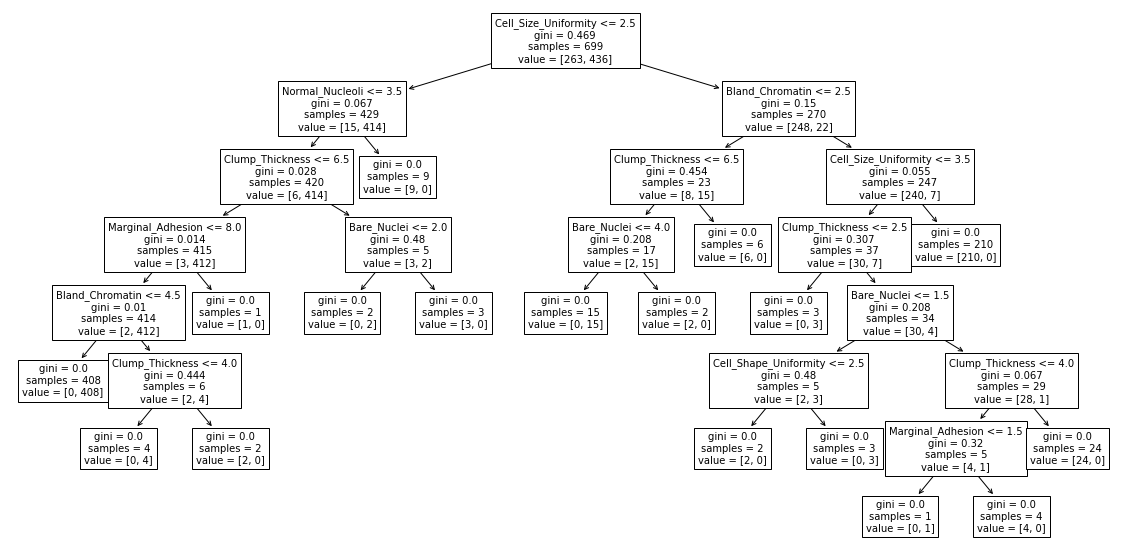

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))
txt = tree.plot_tree(clf.fit(X, cluster_labels),fontsize=10,ax=ax,feature_names=X.columns)

In [35]:
os.environ['CONDA_PREFIX']+r"\pkgs\graphviz-2.38.0-h6538335_1011\Library\bin\graphviz"

'C:\\Users\\Francisco\\Anaconda3\\pkgs\\graphviz-2.38.0-h6538335_1011\\Library\\bin\\graphviz'

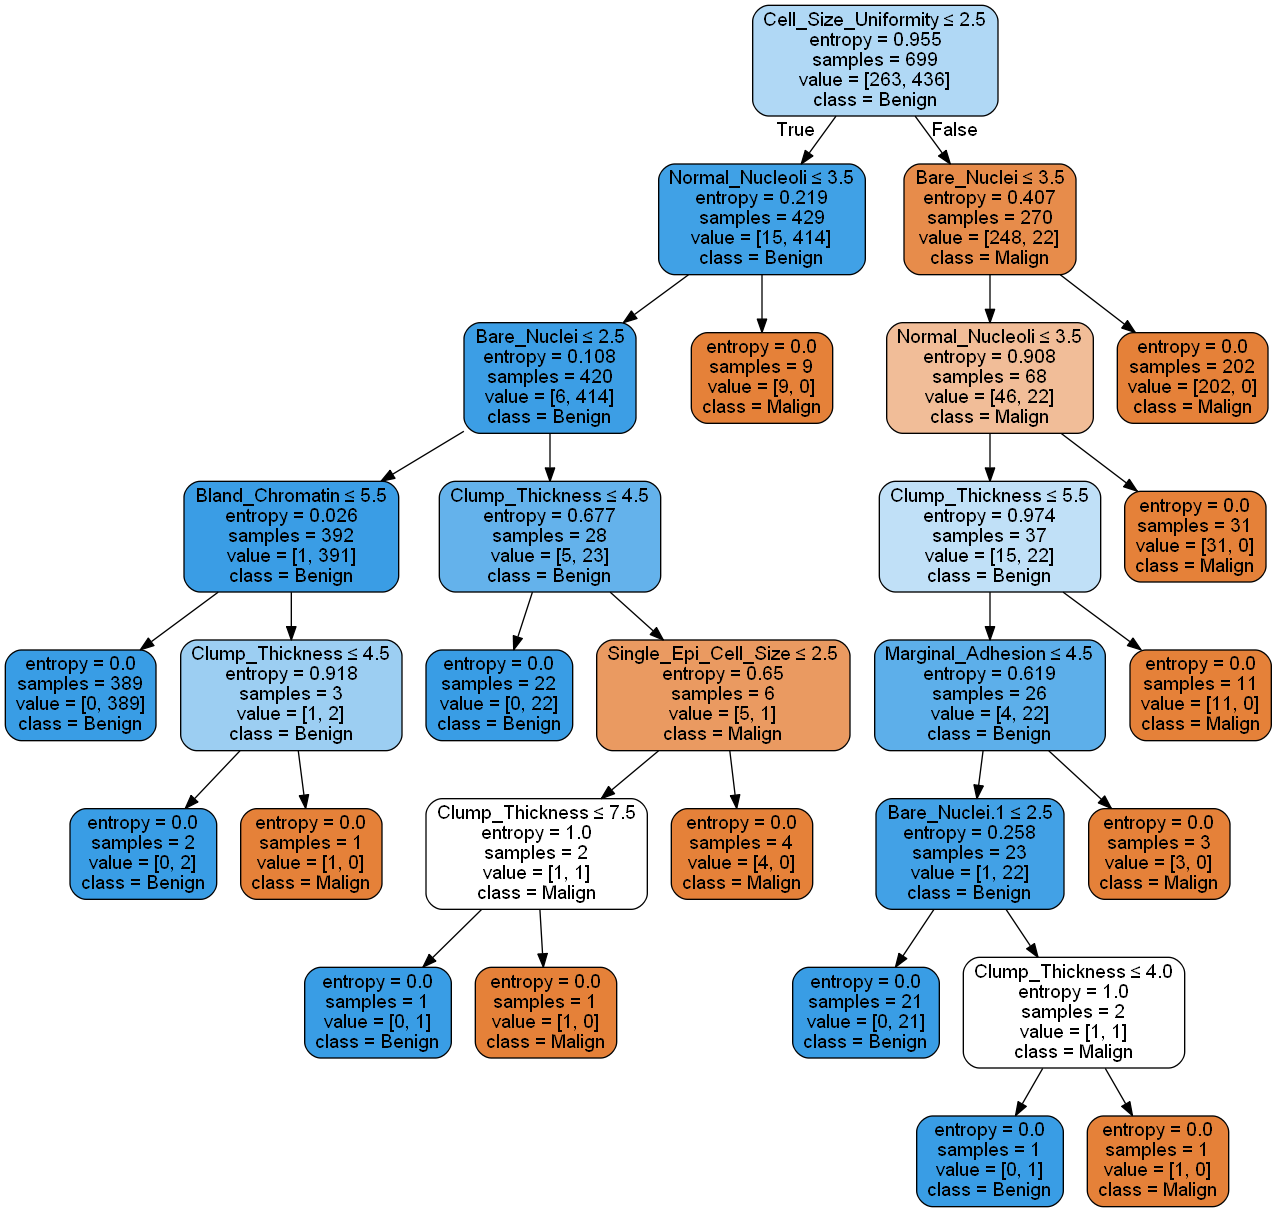

In [36]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\pkgs\graphviz-2.38.0-h6538335_1011\Library\bin\graphviz"

dtree=tree.DecisionTreeClassifier(criterion='entropy')
dtree.fit(X,cluster_labels)

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X.columns,
                class_names=['Malign', 'Benign'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# ?? Ainda não apanhei bem estes gráficos, afinal...

### predicted condition nr_3:

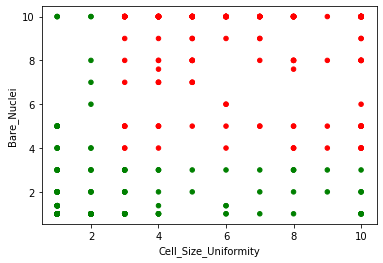

In [56]:
X.plot.scatter(x='Cell_Size_Uniformity',y='Bare_Nuclei',c=((X.Cell_Size_Uniformity>2.5) & (X.Bare_Nuclei >3.5)).map({True:'r',False:'g'}))

### real:

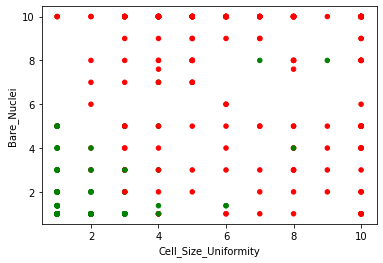

In [55]:
X.plot.scatter(x='Cell_Size_Uniformity',y='Bare_Nuclei',c=y_color)

### Plot the 3 best conditions that explain the predicted cluster

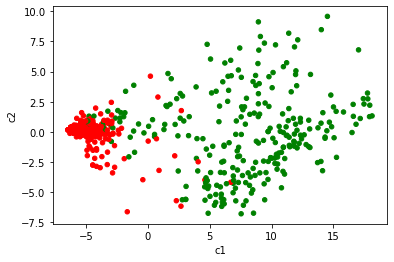

In [42]:
pca_fitted.plot.scatter('c1','c2',c=(X.Cell_Size_Uniformity<=2.5).map({True:'r',False:'g'}))

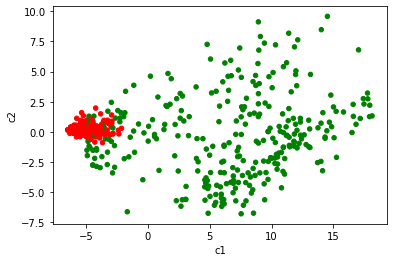

In [46]:
#Bland_Chromatin<=2.5
pca_fitted.plot.scatter('c1','c2',c=((X.Cell_Size_Uniformity<=2.5)&(X.Normal_Nucleoli<=3.5)&(X.Bare_Nuclei<=2.5)&(X.Bland_Chromatin<=5.5)).map({True:'r',False:'g'}))

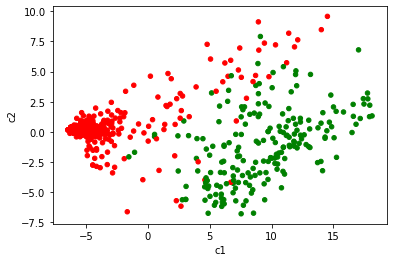

In [47]:
#Cell_Size_Uniformity<=2.5
pca_fitted.plot.scatter('c1','c2',c=((X.Cell_Size_Uniformity>2.5) & (X.Bare_Nuclei >3.5)).map({True:'g',False:'r'}))